In [1]:
import os
import inspect
import re
import pandas as pd

from getpass import getpass
from langchain import OpenAI, PromptTemplate
from langchain.chains import LLMChain, LLMMathChain, TransformChain, SequentialChain
from langchain.callbacks import get_openai_callback

from getpass import getpass
os.environ["LANGCHAIN_HANDLER"] = "langchain"

In [2]:
OPENAI_API_KEY = getpass()

In [3]:
llm = OpenAI(
    model_name="gpt-3.5-turbo",
    temperature=0, 
    openai_api_key=OPENAI_API_KEY
    )
template = """Please do a best effort binary classification for the five big five traits neuroticism, extraversion, openness for experience, agreeableness and conscientiousness for the following German text. 
Please classify with a binary 1 if you think the peculiarity of the dimension is above average in that person or 0 if its below average. Try to evaluate the peculiarity of each dimension on a scale from 1-100.
Keep in mind these mean values for each dimension in the test subjects:
Neuroticism: 55.7625
Extraversion: 65.1
Openness: 68.775
Agreeableness: 69.5625
Conscientousness: 76.7875
That means, most subjects scored really high in conscientiousness and comparably rather low in neuroticism.

Do the classification based on reasoning and context, but answer ONLY with a response structured like that: 
(0, 0, 0, 0, 0) 
where each number can be either a 0 or a 1 that resembles the binary classification result of the respective trait. 
Here is their order: (neuroticism, extraversion, openness, agreeableness, conscientiousness)

German Human Text:
{text}
Do the classification:"""
prompt = PromptTemplate(input_variables=["text"], template=template)
chain = LLMChain(llm=llm, prompt=prompt)

In [4]:
file_path = "datasets/sds/test_04.csv"
df = pd.read_csv(file_path, usecols=["text", "labels"])

print(df.head())

                                                text           labels
0  Durch Empfehlung. Über das Hide the Pain Harol...  (0, 0, 0, 0, 0)
1  Durch einen Rundgang. Weiß ich nicht mehr. Diä...  (0, 1, 0, 0, 1)
2  Ich bin im Josephs. Hallo. Ich habe Aufzeichnu...  (1, 1, 1, 1, 0)
3  Berufsschule. In der famiele. Heute morgen auf...  (0, 0, 1, 1, 1)
4  Ich hab den Link von einer Freundin bekommen.....  (1, 0, 1, 1, 1)


In [5]:
texts = df["text"].tolist()


In [6]:
data = []
for i, eg in enumerate(texts):
    res = chain.run(texts[i])
    data.append({
        "text": texts[i],
        "cf": res
    })

df_results = pd.DataFrame(data)
df_results

,text,cf
0,Durch Empfehlung. Über das Hide the Pain Harol...,"(0, 1, 1, 1, 1)"
1,Durch einen Rundgang. Weiß ich nicht mehr. Diä...,"(0, 1, 1, 1, 1)"
2,Ich bin im Josephs. Hallo. Ich habe Aufzeichnu...,"(0, 0, 1, 0, 1)"
3,Berufsschule. In der famiele. Heute morgen auf...,"(1, 0, 1, 1, 1) \n\nExplanation:\n- Neuroticis..."
4,Ich hab den Link von einer Freundin bekommen.....,"(0, 1, 1, 1, 1)"
5,Das Zukunftsmuseum (?) in nürnberg. Als ich ei...,"(0, 0, 1, 0, 0)"
6,Über Familie. Als ich mit Freunden am See war ...,"(0, 1, 1, 1, 1)"
7,Ich habe da so einen Link bekommen.. Das will ...,"(1, 0, 0, 1, 1)"
8,ich musste. gestern. hier zu chatten. na eben ...,"(1, 0, 0, 0, 0) \n\nExplanation: \nThe text sh..."
9,Mir hat jemand Bescheid gesagt.. Gar nicht.......,"(1, 0, 1, 1, 0)"


In [7]:
# filter out potential additional strings 
# Use regular expression to extract the label tuples
df_results["labels"] = df_results["cf"].str.extract(r'(\(\d, \d, \d, \d, \d\))')
df_results

,text,cf,labels
0,Durch Empfehlung. Über das Hide the Pain Harol...,"(0, 1, 1, 1, 1)","(0, 1, 1, 1, 1)"
1,Durch einen Rundgang. Weiß ich nicht mehr. Diä...,"(0, 1, 1, 1, 1)","(0, 1, 1, 1, 1)"
2,Ich bin im Josephs. Hallo. Ich habe Aufzeichnu...,"(0, 0, 1, 0, 1)","(0, 0, 1, 0, 1)"
3,Berufsschule. In der famiele. Heute morgen auf...,"(1, 0, 1, 1, 1) \n\nExplanation:\n- Neuroticis...","(1, 0, 1, 1, 1)"
4,Ich hab den Link von einer Freundin bekommen.....,"(0, 1, 1, 1, 1)","(0, 1, 1, 1, 1)"
5,Das Zukunftsmuseum (?) in nürnberg. Als ich ei...,"(0, 0, 1, 0, 0)","(0, 0, 1, 0, 0)"
6,Über Familie. Als ich mit Freunden am See war ...,"(0, 1, 1, 1, 1)","(0, 1, 1, 1, 1)"
7,Ich habe da so einen Link bekommen.. Das will ...,"(1, 0, 0, 1, 1)","(1, 0, 0, 1, 1)"
8,ich musste. gestern. hier zu chatten. na eben ...,"(1, 0, 0, 0, 0) \n\nExplanation: \nThe text sh...","(1, 0, 0, 0, 0)"
9,Mir hat jemand Bescheid gesagt.. Gar nicht.......,"(1, 0, 1, 1, 0)","(1, 0, 1, 1, 0)"


In [8]:
# Convert the "labels" column to a list of tuples
y_true = df["labels"].apply(eval).tolist()
y_pred = df_results["labels"].apply(eval).tolist()



In [9]:
from sklearn.metrics import classification_report

# Assuming y_pred and y_true are lists of tuples, as shown in the question

num_dimensions = 5
dimension_label_lookup = ["Neuroticism", "Extraversion", "Openness", "Agreeableness", "Conscientiousness"]
classification_reports = []
# Iterate over each dimension
for i in range(num_dimensions):
    y_true_dim = [yt[i] for yt in y_true]
    y_pred_dim = [yp[i] for yp in y_pred]

    print(f"Classification report for dimension {dimension_label_lookup[i]}:")
    classification_reports.append(classification_report(y_true_dim, y_pred_dim))

    print()

Classification report for dimension Neuroticism:

Classification report for dimension Extraversion:

Classification report for dimension Openness:

Classification report for dimension Agreeableness:

Classification report for dimension Conscientiousness:



In [10]:
for report in classification_reports:
    print(report)

              precision    recall  f1-score   support

           0       0.53      0.77      0.62        13
           1       0.40      0.18      0.25        11

    accuracy                           0.50        24
   macro avg       0.46      0.48      0.44        24
weighted avg       0.47      0.50      0.45        24

              precision    recall  f1-score   support

           0       0.64      0.54      0.58        13
           1       0.54      0.64      0.58        11

    accuracy                           0.58        24
   macro avg       0.59      0.59      0.58        24
weighted avg       0.59      0.58      0.58        24

              precision    recall  f1-score   support

           0       0.75      0.23      0.35        13
           1       0.50      0.91      0.65        11

    accuracy                           0.54        24
   macro avg       0.62      0.57      0.50        24
weighted avg       0.64      0.54      0.49        24

              preci

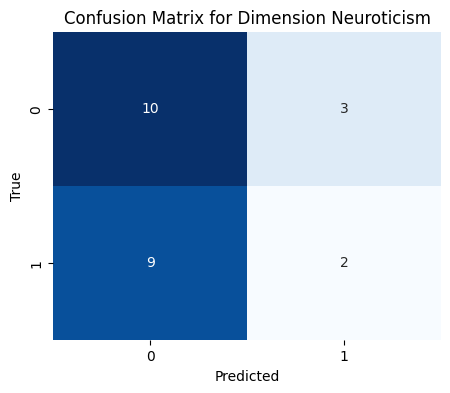

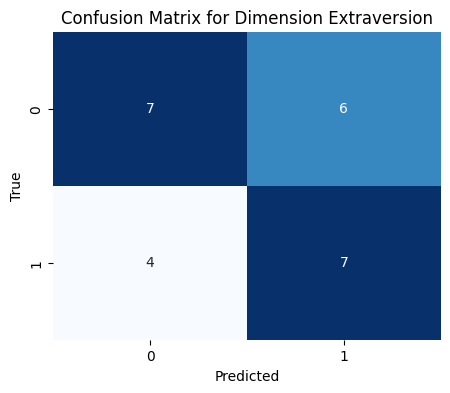

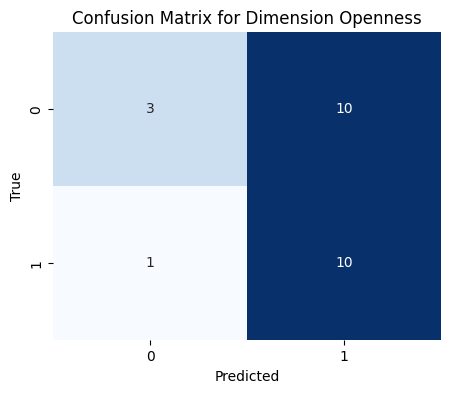

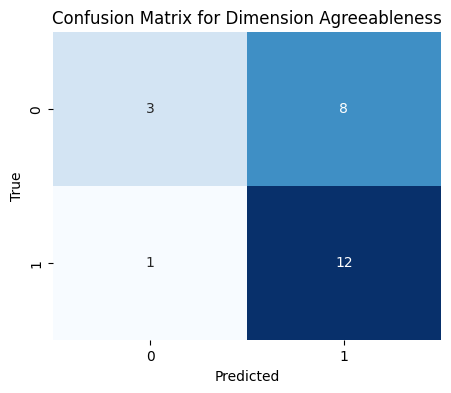

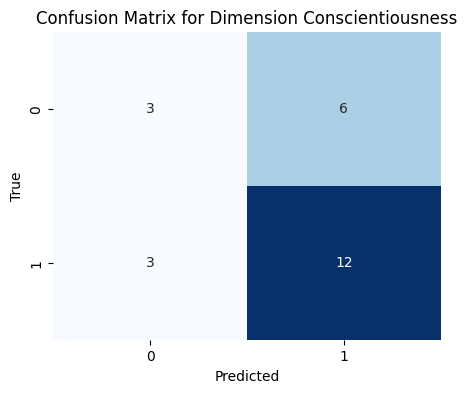

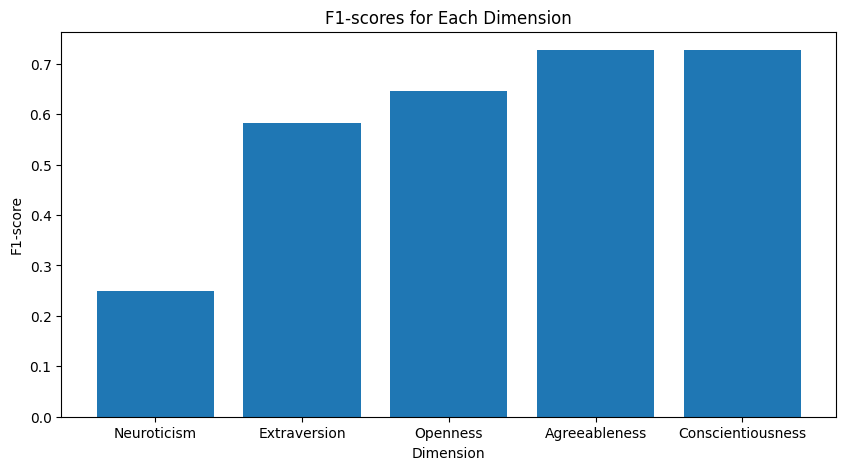

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

# Assuming y_pred and y_true are lists of tuples, as shown in the question

num_dimensions = 5
f1_scores = []

# Iterate over each dimension
for i in range(num_dimensions):
    y_true_dim = [yt[i] for yt in y_true]
    y_pred_dim = [yp[i] for yp in y_pred]

    # Compute the confusion matrix and F1-score
    cm = confusion_matrix(y_true_dim, y_pred_dim)
    f1 = f1_score(y_true_dim, y_pred_dim)

    # Append the F1-score to the list
    f1_scores.append(f1)

    # Plot the confusion matrix heatmap
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix for Dimension {dimension_label_lookup[i]}")
    plt.show()

# Plot the F1-scores bar plot
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(dimension_label_lookup)), f1_scores)
plt.xlabel("Dimension")
plt.ylabel("F1-score")
plt.title("F1-scores for Each Dimension")
plt.xticks(np.arange(len(dimension_label_lookup)), dimension_label_lookup)
plt.show()

In [12]:
#%pip install tabulate

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score
from tabulate import tabulate

# Assuming y_pred and y_true are lists of tuples, as shown in the question

num_dimensions = 5
dimension_label_lookup = ["Neuroticism", "Extraversion", "Openness", "Agreeableness", "Conscientiousness"]

metrics = []

for i in range(num_dimensions):
    y_true_dim = [yt[i] for yt in y_true]
    y_pred_dim = [yp[i] for yp in y_pred]

    precision = precision_score(y_true_dim, y_pred_dim)
    recall = recall_score(y_true_dim, y_pred_dim)
    f1 = f1_score(y_true_dim, y_pred_dim)

    metrics.append([dimension_label_lookup[i], precision, recall, f1])

headers = ["Dimension", "Precision", "Recall", "F1-score"]
table = tabulate(metrics, headers=headers, tablefmt="pretty", floatfmt=".4f")

print(table)

+-------------------+--------------------+---------------------+---------------------+
|     Dimension     |     Precision      |       Recall        |      F1-score       |
+-------------------+--------------------+---------------------+---------------------+
|    Neuroticism    |        0.4         | 0.18181818181818182 | 0.25000000000000006 |
|   Extraversion    | 0.5384615384615384 | 0.6363636363636364  | 0.5833333333333334  |
|     Openness      |        0.5         | 0.9090909090909091  | 0.6451612903225806  |
|   Agreeableness   |        0.6         | 0.9230769230769231  | 0.7272727272727274  |
| Conscientiousness | 0.6666666666666666 |         0.8         | 0.7272727272727272  |
+-------------------+--------------------+---------------------+---------------------+


[['lightblue', 'lightblue', 'lightblue', 'lightblue'], ['lightblue', 'lightblue', 'lightblue', 'lightblue'], ['lightblue', 'lightblue', 'lightblue', 'lightblue'], ['lightblue', 'lightblue', 'lightblue', 'lightblue'], ['lightblue', 'lightblue', 'lightblue', 'lightblue']]


ValueError: 'cellColours' must have 5 rows

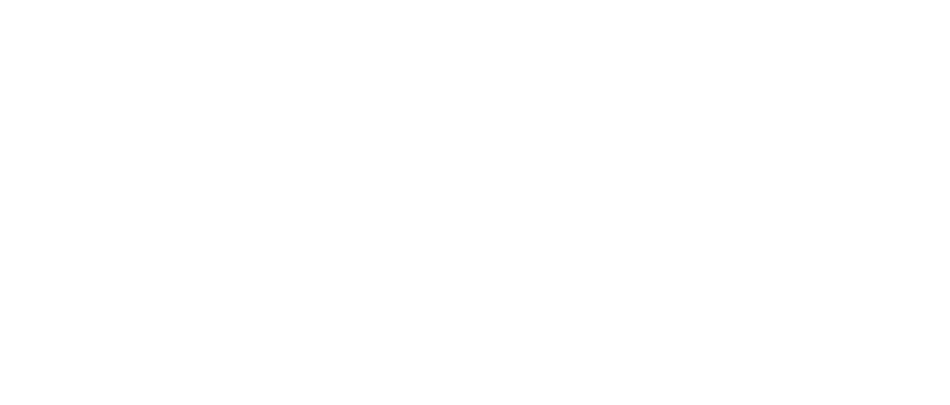

In [29]:
# Round the metrics to two decimal points
rounded_metrics = [[dimension] + [round(metric, 2) for metric in values] for dimension, *values in metrics]

headers = ["Dimension", "Precision", "Recall", "F1-score"]
data = np.array(rounded_metrics)

# Create a table as an image
fig, ax = plt.subplots(figsize=(12, 5))
ax.axis('tight')
ax.axis('off')

# Table settings
cell_colors = [["lightblue"] * 4] * 4  # Light blue background for data cells
print(cell_colors)
header_colors = [["steelblue"] * 4]  # Steel blue background for header cells
row_colors = header_colors + cell_colors

the_table = ax.table(cellText=data, colLabels=headers, cellLoc='center', loc='center', colWidths=[0.3, 0.2, 0.2, 0.2],
                     cellColours=row_colors)

# Modify font size and cell padding
for key, cell in the_table.get_celld().items():
    cell.set_edgecolor("w")  # Set cell border color to white
    if key[0] == 0:  # Header cells
        cell.set_text_props(fontproperties=plt.FontProperties(weight='bold', size=14))
    else:  # Data cells
        cell.set_text_props(fontproperties=plt.FontProperties(size=12))
    cell.PAD = 0.1  # Increase cell padding

# Save the table as an image file
plt.savefig("metrics_table.png", dpi=300, bbox_inches='tight')

# Display the table
plt.show()

## Check classification by looking at the reasoning behind it